# delegation.ipynb

This notebook is used to test the implementatin of 'delegation' synapses in draculab.

Delegation synapses: 
* `diff_hebb_subsnorm_synapse`

By: Sergio Verduzco Flores                                
August-September 2017

In [1]:
from draculab import *
from matplotlib import pyplot as plt
import numpy as np
import time

In this simulation you have a unit receiving several inputs. Among them, one is an increasing function of the unit's activity. This means $I(t) = f(u(t-\Delta))$, and $x_2 > x_1 \Rightarrow f(x_2) \geq f(x_1)$, where $I$ is the input, $u$ is the unit's activity, and $\Delta$ is the delay of the input. The other inputs will be random processes independent of $u$.

The rule will work if the synapse for $I$ becomes the one with the largest weight.

In [2]:
class delegation1():
    def __init__(self):
        """ Sets all the default parameters. """
        self.n_inp = 3 # number of additional inputs
        # Network parameters
        self.md = 0.1 # minimum delay in the network
        self.min_buff_size = 3 # minimum buffer size
        self.rtol = 1e-4 # relative tolerance of the ODE solver
        self.atol = 1e-4 # absolute tolerance of the ODE solver
        # source unit parameters
        self.inp_init_val = 0.
        self.inp_tau_fast = 0.2
        self.inp_tau_mid = 3.
        # delegate unit parameters
        self.u_type = unit_types.sigmoidal
        self.u_init_val = 0.5
        self.u_tau = 5
        self.u_slope = 0.5
        self.u_thresh = 0.2
        self.u_tau_fast = 0.2
        self.u_tau_mid = 3.
        # connection parameters
        self.conn_delay = 0.2
        self.syn_type = synapse_types.diff_hebbsnorm
        self.init_w = {'distribution':'uniform', 'low':0.1, 'high':0.4}
        self.lrate = 1./30.
        
    def build(self):
        """ Run this before first run(), or if you change the paramaters. """
        # creating network
        net_params = {'min_delay' : self.md, 
                      'min_buff_size' : self.min_buff_size, 
                      'rtol':self.rtol, 
                      'atol':self.atol }
        self.net = network(net_params)
        # creating input units
        inp_params = {'type' : unit_types.source, 
                      'init_val' : self.inp_init_val, 
                      'function' : lambda x: None,
                      'tau_fast' : self.inp_tau_fast,
                      'tau_mid' : self.inp_tau_mid }
        self.inp = self.net.create_units(self.n_inp, inp_params)
        self.I = self.net.create_units(1, inp_params) # the input that increases with u
        self.inp_ws = self.net.create_units(len(self.inp), inp_params) # to track the weights
        self.I_w = self.net.create_units(1, inp_params) # to track the main weight
        # creating delegate unit
        u_params = {'type' : self.u_type,
                    'init_val' : self.u_init_val, 
                    'tau' : self.u_tau,
                    'slope' : self.u_slope,
                    'thresh' : self.u_thresh,
                    'tau_fast' : self.u_tau_fast,
                    'tau_mid' : self.u_tau_mid }
        self.u = self.net.create_units(1, u_params)
        # setting the input functions uncorrelated with the unit's activity
        n_comp = np.random.randint(4, 10, self.n_inp) # number of sin,cos components for each input
        freqs = [range(0, c) + np.random.normal(0., 0.5, c) for c in n_comp] # frequency of each component
        sin_amps = [np.random.normal(1., 1, c) for c in n_comp] # amplitudes for sin components
        cos_amps = [np.random.normal(1., 1, c) for c in n_comp] # amplitudes for cos components
        def make_fun(i):
            return lambda t: sum(sin_amps[i]*np.sin(freqs[i]*t) + cos_amps[i]*np.cos(freqs[i]*t))
        functions = [make_fun(i) for i in range(self.n_inp)]
        for idx, uni in enumerate(self.inp):
            self.net.units[uni].set_function(functions[idx])
        # setting the transformation I = f(u)
        self.net.units[self.I[0]].set_function(lambda t: 0.5*self.net.units[self.u[0]].get_act(t-self.net.min_delay))
        # connecting
        conn_spec = {'rule' : 'all_to_all',
                     'delay' : self.conn_delay }
        syn_spec = {'type' : self.syn_type,
                    'init_w' : self.init_w,
                    'lrate' : self.lrate }
        self.net.connect(self.inp+self.I, self.u, conn_spec, syn_spec)
        # tracking the weights with the 'weights' units
        #for idx, uni in enumerate(self.inp_ws):
        #    self.net.units[uni].set_function(self.net.syns[self.u[0]]:
        for syn in self.net.syns[self.u[0]]:
            if syn.preID in self.inp:
                self.net.units[self.inp_ws[syn.preID-self.inp[0]]].set_function(syn.get_w)
            elif syn.preID == self.I[0]:
                self.net.units[self.I_w[0]].set_function(syn.get_w)
                                             
    def plot_inputs(self, t_min, t_max):
        t_vals = np.linspace(t_min, t_max, 300)
        f_vals = np.transpose([np.array([self.net.units[i].get_act(t) for t in t_vals]) for i in range(self.n_inp)])
        fig = plt.figure(figsize=(12,8))
        plt.plot(t_vals, f_vals)
        plt.show()
        
    def run(self, t_sim):
        start_time = time.time()
        self.times, self.units, plants = self.net.run(t_sim)  # simulating
        print('Execution time is %s seconds' % (time.time() - start_time)) 

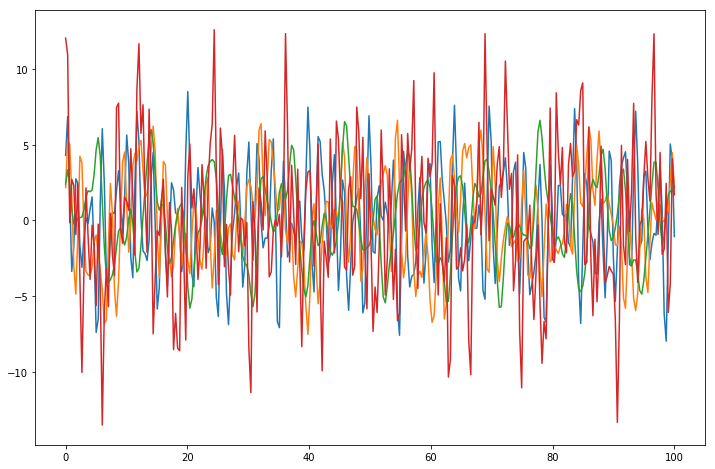

Execution time is 0.6507306098937988 seconds


In [3]:
dely = delegation1()
dely.n_inp = 4
dely.build()
sim_time = 100.
dely.plot_inputs(0.,sim_time)
dely.run(sim_time)

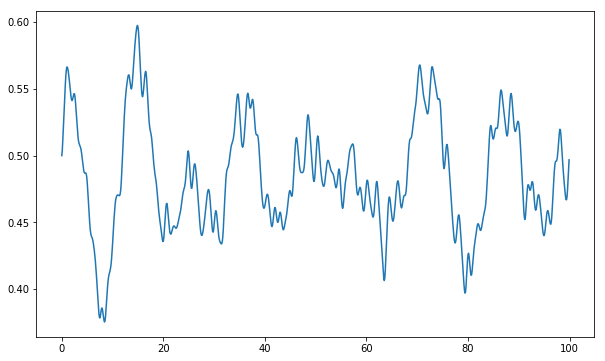

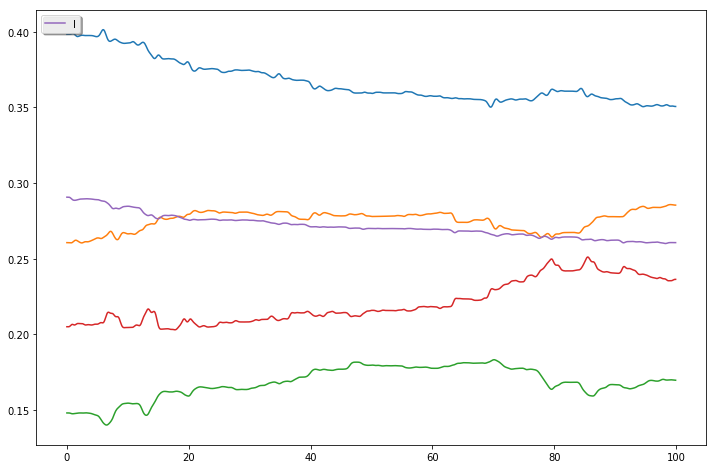

In [4]:
# Plot the unit's activity
act_fig = plt.figure(figsize=(10,6))
plt.plot(dely.times, dely.units[dely.u[0]])

# Plot the evolution of the synaptic weights
w_fig = plt.figure(figsize=(12,8))
weights = np.transpose([dely.units[dely.inp_ws[i]] for i in range(dely.n_inp)])
plt.plot(dely.times, weights)
plt.plot(dely.times, dely.units[dely.I_w[0]], label="I")
plt.legend(loc="upper left", bbox_to_anchor=[0, 1], ncol=1, shadow=True)

# Plot the derivatives of the u activity and the I input
# TODO
plt.show()

In this simulation you have a pendulum with no friction, being moved by gravity, a random torque, and a positive torque that comes from the output of a unit. Among the inputs of the unit are sigmoidal functions of the pendulum's angle (modulo $2\pi$) and its angular velocity. Other inputs are either random and uncorrelated to the pendulum's state, or nonmonotonic functions of a state variable.

As before, the learning rule must select the inputs from angle and angular velocity.